In [1]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

print("Project root added to path:", project_root)

Project root added to path: /Users/krishna/Desktop/NIRANJAN/rl-derivative_hedging


In [7]:
%pip install yfinance
%pip install scipy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.3 MB/s  0:00:03 eta 0:00:01
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.9 MB/s  0:00:00 eta 0:00:01
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 4.0 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf
data = yf.download("SPY", start="2018-01-01", end="2023-01-01")
print(data.head())

/Users/krishna/Desktop/NIRANJAN/rl-derivative_hedging/.venv/lib/python3.13/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2018-01-02  237.208237  237.243547  235.999121  236.387453  86655700
2018-01-03  238.708603  238.858652  237.375914  237.375914  90070400
2018-01-04  239.714706  240.200136  238.770377  239.352877  80636400
2018-01-05  241.312164  241.435710  240.014786  240.509023  83524000
2018-01-08  241.753433  241.912289  240.923816  241.215052  57319200


In [4]:
print(data.shape)
print(data.columns)

(1259, 5)
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [5]:
from pricing.black_scholes import bs_call_price, bs_delta, bs_gamma

S = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2

print("Call Price:", bs_call_price(S, K, T, r, sigma))
print("Delta:", bs_delta(S, K, T, r, sigma))
print("Gamma:", bs_gamma(S, K, T, r, sigma))

Call Price: 10.450583572185565
Delta: 0.6368306511756191
Gamma: 0.018762017345846895


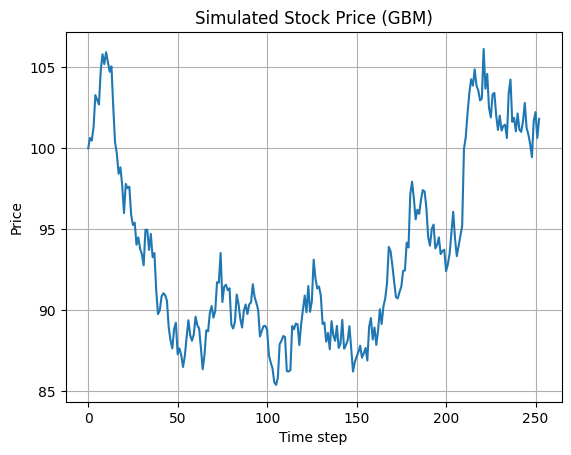

In [8]:
from simulator.gbm import simulate_gbm
import matplotlib.pyplot as plt

prices = simulate_gbm(
    S0=100,
    mu=0.05,
    sigma=0.2,
    T=1.0,
    steps=252,
    seed=42
)

plt.plot(prices)
plt.title("Simulated Stock Price (GBM)")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.grid(True)
plt.show()